In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [5]:
np.random.seed(42)

In [6]:
def a20_index(y_train,y_pred):
  total = 0
  acc = 0
  for i in range(len(y_train.values)):

    temp = np.abs((y_pred[i]-y_train.values[i])/y_train.values[i])
    if temp<=0.2:
      total += 1
      acc += 1
    else:
      total += 1

  a20 = acc/total
  return a20

In [7]:
def mape(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Avoid division by zero by adding a small epsilon to y_true
    epsilon = 1e-10
    mape_value = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    return mape_value


In [8]:
def vaf(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    numerator = np.var(y_true - y_pred)
    denominator = np.var(y_true)

    vaf_value = (1 - (numerator / denominator)) * 100
    return vaf_value


In [9]:
def rsr(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute RMSE
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))

    # Compute standard deviation of y_true
    y_mean = np.mean(y_true)
    std_dev = np.sqrt(np.mean((y_true - y_mean) ** 2))

    rsr_value = rmse / std_dev
    return rsr_value


In [10]:
def evaluation_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mape_value = mape(y_true, y_pred)
  vaf_value = vaf(y_true, y_pred)
  rsr_value = rsr(y_true, y_pred)
  a20 = a20_index(y_true, y_pred)
  return mae, r2, rmse, mape_value, vaf_value, rsr_value, a20

In [11]:
# Perform Randomized Search CV for each regressor
def randomized_search(model, param_grid, X, y, cv=5, n_iter=20):
    random_search = RandomizedSearchCV(
        estimator=model, param_distributions=param_grid,
        scoring='neg_mean_squared_error', cv=cv, n_iter=n_iter,
        verbose=1, random_state=42, n_jobs=-1
    )
    random_search.fit(X, y)
    return random_search.best_params_

In [12]:
def randomized_search(model, param_grid, X, y, cv=5, n_iter=20):
    try:
        random_search = RandomizedSearchCV(
            estimator=model, param_distributions=param_grid,
            scoring='neg_mean_squared_error', cv=cv, n_iter=n_iter,
            verbose=1, random_state=42, n_jobs=-1
        )
        random_search.fit(X, y)
        return random_search.best_params_
    except AttributeError as e:
        print(f"Error in RandomizedSearchCV: {e}")


In [13]:
def get_activation(layer):
    if hasattr(layer, 'activation'):
        return layer.activation.__name__
    return "linear"

def print_equations(model, input_names=None):
    if input_names is None:
        input_dim = model.input_shape[-1]   # FIXED
        input_names = [f"x{i+1}" for i in range(input_dim)]

    prev_outputs = input_names

    for layer_idx, layer in enumerate(model.layers):
        if not hasattr(layer, "get_weights"):  # skip if no weights
            continue

        weights, biases = layer.get_weights()
        activation = layer.activation.__name__ if hasattr(layer, 'activation') else "linear"
        curr_outputs = []

        print(f"\n--- Layer {layer_idx+1} ({activation}) ---")
        for j in range(weights.shape[1]):
            eq_terms = [f"({weights[i, j]:.4f}*{prev_outputs[i]})"
                        for i in range(weights.shape[0])]
            eq = " + ".join(eq_terms) + f" + ({biases[j]:.4f})"
            if activation != "linear":
                eq = f"{activation}({eq})"
            neuron_name = f"a{layer_idx+1}_{j+1}"
            print(f"{neuron_name} = {eq}")
            curr_outputs.append(neuron_name)

        prev_outputs = curr_outputs

# print_equations(ann)

# Stone Chips

## EDA

In [ ]:
stone_df = pd.read_excel("/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/Stone CM.xlsx")
stone_df.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),Actual
0,340.8,1046.4,1249.2,0.0,231.6,22.334836
1,340.8,1046.4,1249.2,0.0,231.6,21.718515
2,340.8,1046.4,1249.2,0.0,231.6,21.965002
3,340.8,1046.4,936.0,272.4,231.6,20.615770
4,340.8,1046.4,936.0,272.4,231.6,22.581324


In [ ]:
stone_df = stone_df.dropna()
stone_df.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),Actual
0,340.8,1046.4,1249.2,0.0,231.6,22.334836
1,340.8,1046.4,1249.2,0.0,231.6,21.718515
2,340.8,1046.4,1249.2,0.0,231.6,21.965002
3,340.8,1046.4,936.0,272.4,231.6,20.615770
4,340.8,1046.4,936.0,272.4,231.6,22.581324


In [ ]:
stone_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cement (kg/m3)  75 non-null     float64
 1   FA (kg/m3)      75 non-null     float64
 2   CA (kg/m3)      75 non-null     float64
 3   Slag (kg/m3)    75 non-null     float64
 4   Water (kg/m3)   75 non-null     float64
 5   Actual          75 non-null     float64
dtypes: float64(6)
memory usage: 3.6 KB


In [ ]:
stone_df.describe()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),Actual
count,75.000000,75.000000,75.00000,75.000000,7.500000e+01,75.000000
mean,408.000000,1007.952000,624.24000,541.200000,2.316000e+02,29.637026
std,50.317693,55.394407,444.54777,383.233272,1.430655e-13,6.144042
min,340.800000,928.800000,0.00000,0.000000,2.316000e+02,19.253368
25%,370.800000,962.400000,312.00000,272.400000,2.316000e+02,24.368579
50%,405.600000,1017.600000,624.00000,543.600000,2.316000e+02,29.607000
75%,440.400000,1046.400000,936.00000,816.000000,2.316000e+02,34.522194
max,482.400000,1136.400000,1249.20000,1074.000000,2.316000e+02,44.013293


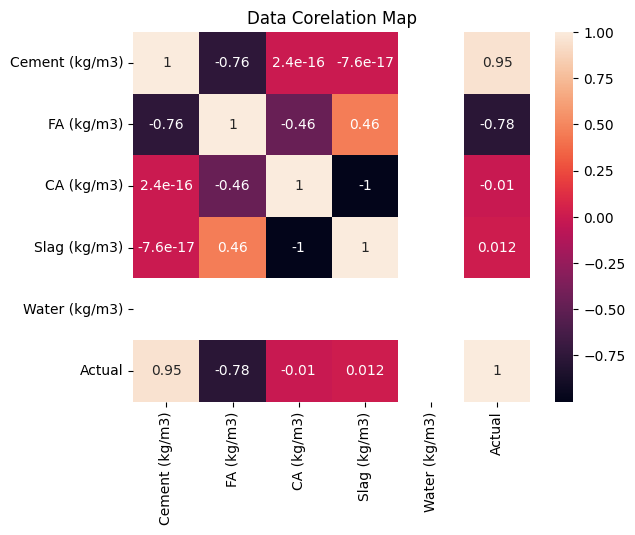

In [ ]:
sns.heatmap(stone_df.corr(), annot=True)
plt.title("Data Corelation Map")
plt.show()

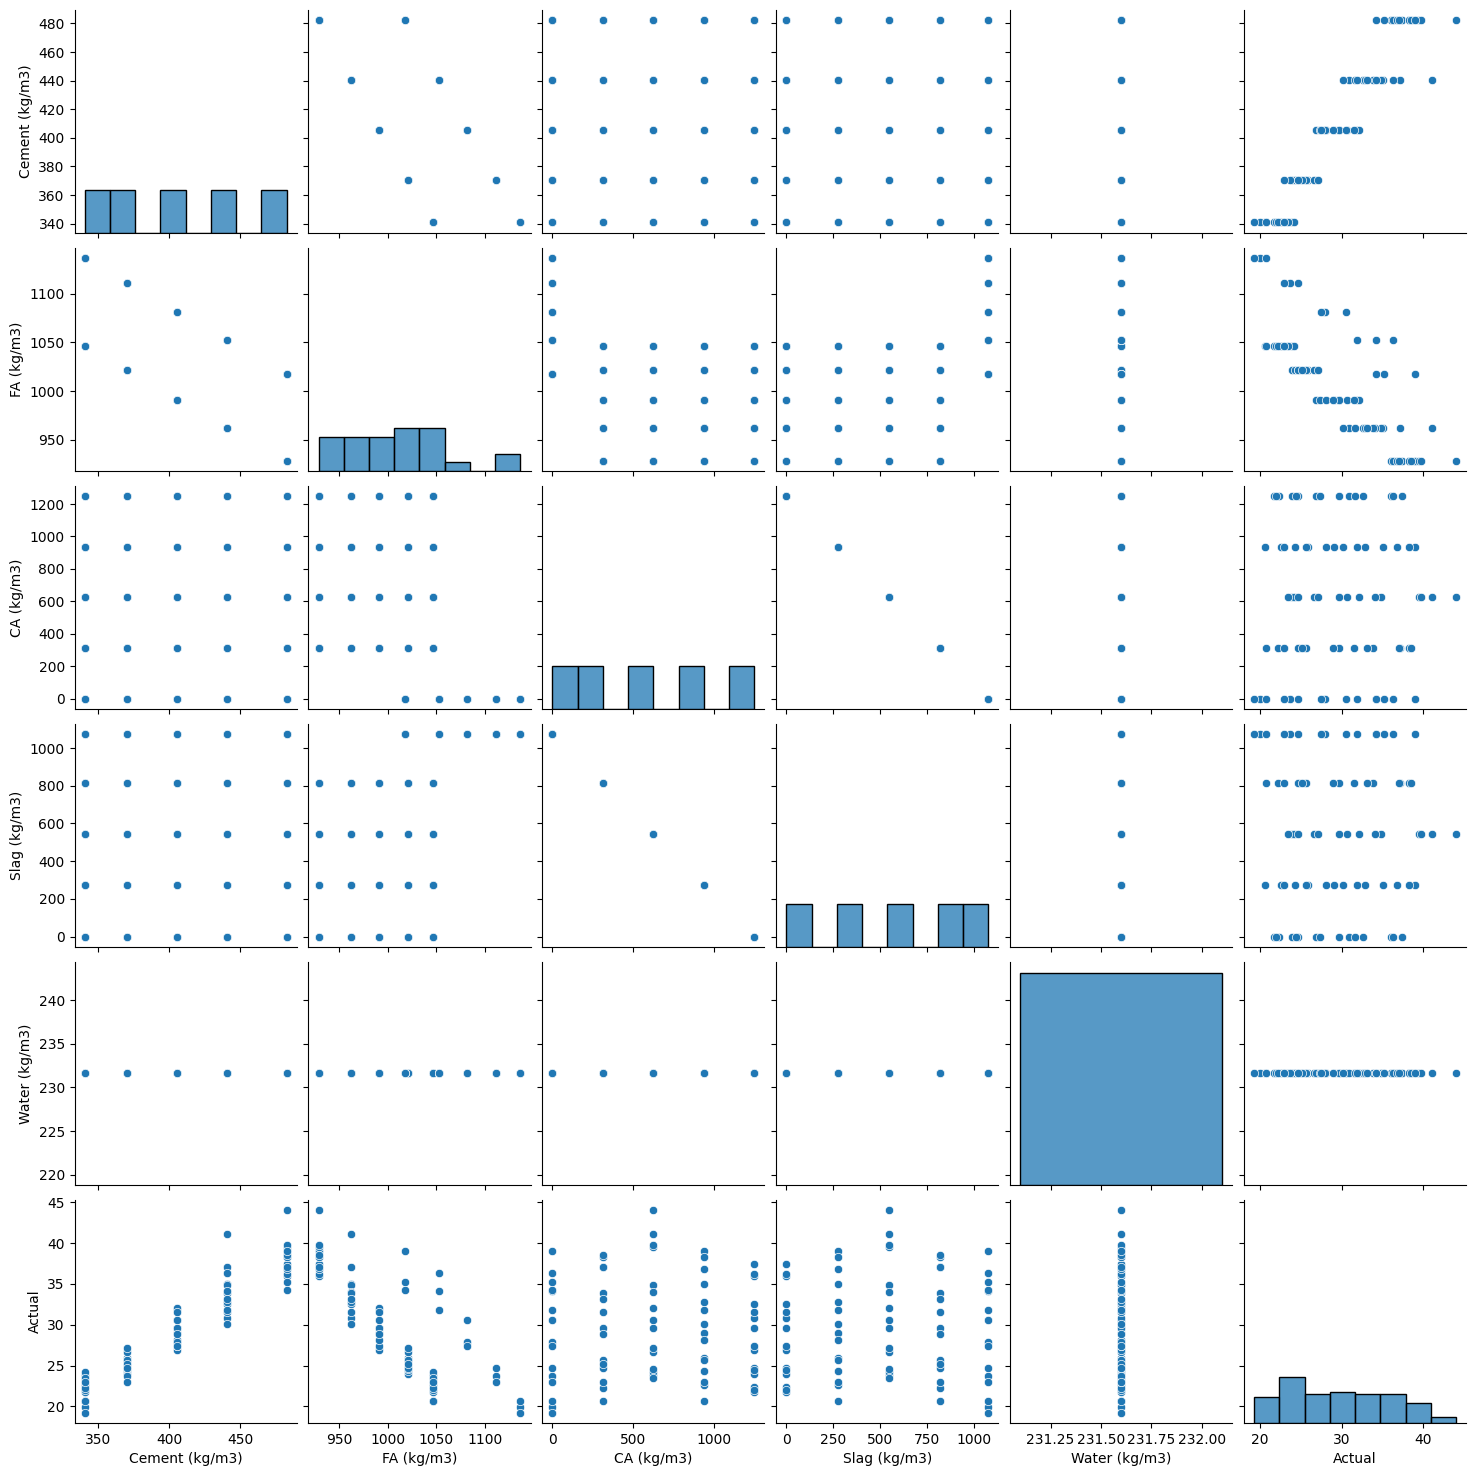

In [ ]:
sns.pairplot(stone_df)
plt.show()

## Data Preprocessing

In [ ]:
stone_df.columns

Index(['Cement (kg/m3)', 'FA (kg/m3)', 'CA (kg/m3)', 'Slag (kg/m3)',
       'Water (kg/m3)', 'Actual'],
      dtype='object')

In [ ]:
X = stone_df.drop("Actual", axis=1)
y = stone_df["Actual"]

In [ ]:
X.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3)
0,340.8,1046.4,1249.2,0.0,231.6
1,340.8,1046.4,1249.2,0.0,231.6
2,340.8,1046.4,1249.2,0.0,231.6
3,340.8,1046.4,936.0,272.4,231.6
4,340.8,1046.4,936.0,272.4,231.6


In [ ]:
X.shape

(75, 5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((52, 5), (23, 5), (52,), (23,))

In [ ]:
# Train = X_train
# Train["Actual"] = y_train
# Test = X_test
# Test["Actual"] = y_test
# Full = X
# Full["Actual"] = y

In [ ]:
Train = X_train.copy()
Train["Actual"] = y_train.copy()

Test = X_test.copy()
Test["Actual"] = y_test.copy()

Full = X.copy()
Full["Actual"] = y.copy()

In [ ]:
X.shape

(75, 5)

In [ ]:
X.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3)
0,340.8,1046.4,1249.2,0.0,231.6
1,340.8,1046.4,1249.2,0.0,231.6
2,340.8,1046.4,1249.2,0.0,231.6
3,340.8,1046.4,936.0,272.4,231.6
4,340.8,1046.4,936.0,272.4,231.6


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

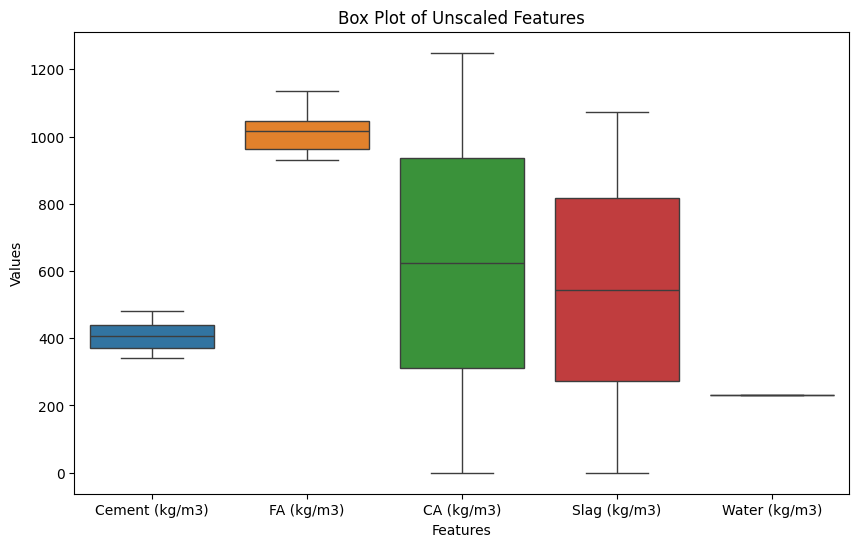

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train)
plt.title("Box Plot of Unscaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
#plt.set_xticklabels(X_train.columns, rotation=45)
plt.show()

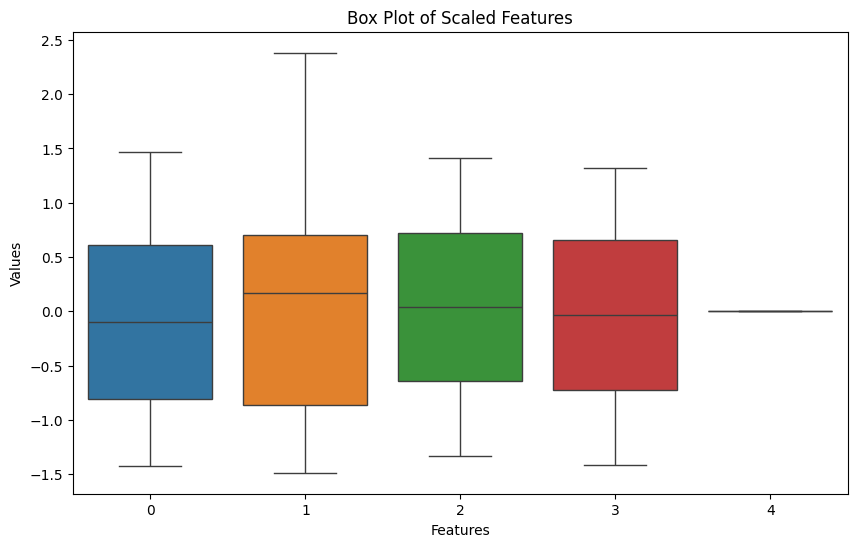

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train_scaled)
plt.title("Box Plot of Scaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

## ANN

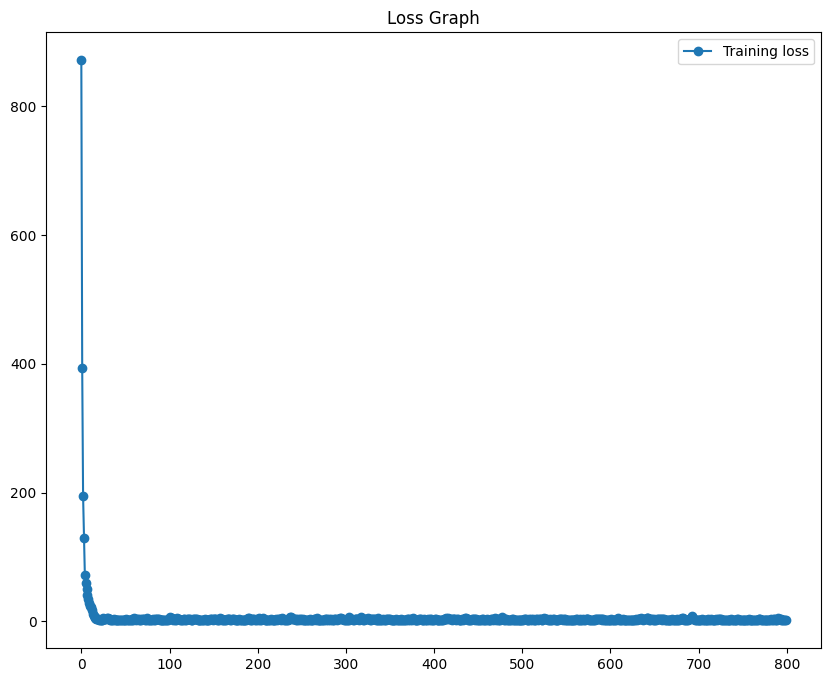

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
ANN Metrics:
MAE: 1.1701560091699814
R2 Score: 0.9430848488443687
RMSE: 1.455972984123535
MAPE: 3.893676919427335
VAF: 95.13092660690712
RSR: 0.23856896519797227
A20: 1.0


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0002)
ann.compile(optimizer=optimizer, loss='mse')

r = ann.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = ann.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("ANN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [ ]:
y_pred_train = ann.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("ANN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
ANN Train Metrics:
MAE: 1.2312440521403003
R2 Score: 0.9368778442673561
RMSE: 1.5319050252649664
MAPE: 4.134117354982141
VAF: 94.80454585910225
RSR: 0.25124123016066435
A20: 1.0


In [ ]:
y_pred_test = ann.predict(X_test_scaled)

print(y_pred_test.shape)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("ANN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(23, 1)
ANN Test Metrics:
MAE: 1.0320437461632923
R2 Score: 0.9566873111452313
RMSE: 1.2676437981218747
MAPE: 3.3500720308847804
VAF: 95.99514495975147
RSR: 0.2081170076057425
A20: 1.0


In [ ]:
# print_equations(ann)

In [ ]:
Train["ANN Predicted"] = y_pred_train
Test["ANN Predicted"] = y_pred_test
Full["ANN Predicted"] = y_pred

## CNN

In [ ]:
X_scaled.shape

(75, 5)

In [ ]:
n_sample,n_features = X_scaled.shape
print(n_sample,n_features)
X_scaled_reshaped = X_scaled.reshape((n_sample,n_features,1))

75 5


In [ ]:
n_sample,n_features = X_train_scaled.shape
print(n_sample,n_features)
X_train_scaled_reshaped = X_train_scaled.reshape((n_sample,n_features,1))

52 5


In [ ]:
n_sample,n_features = X_test_scaled.shape
print(n_sample,n_features)
X_test_scaled_reshaped = X_test_scaled.reshape((n_sample,n_features,1))

23 5


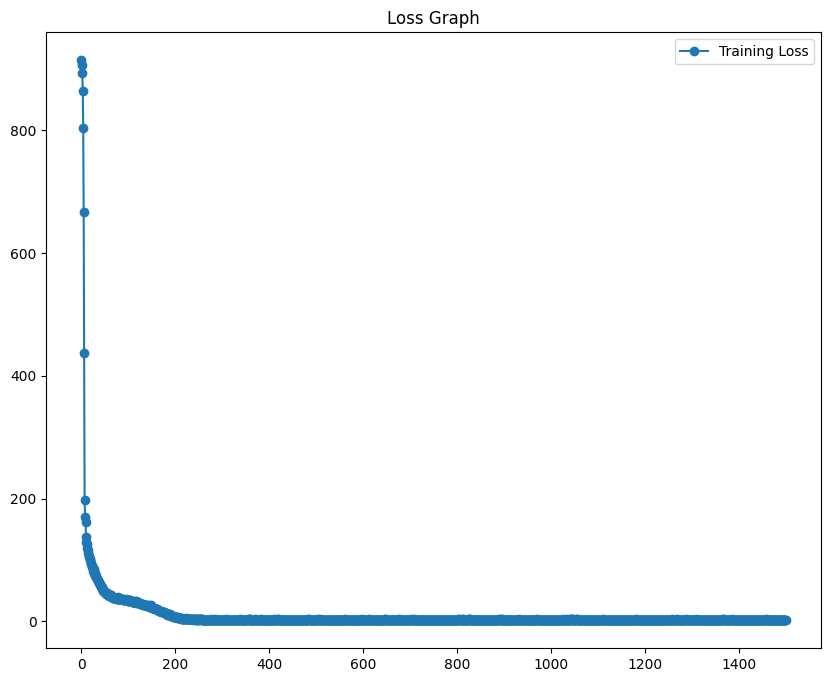

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
CNN Metrics:
MAE: 1.0356471731792536
R2 Score: 0.9495974806214826
RMSE: 1.3701417260993005
MAPE: 3.3634162212182073
VAF: 95.04530595588449
RSR: 0.22450505423824504
A20: 1.0


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu', input_shape=(n_features,1)),
    tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu'),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
cnn.compile(optimizer=optimizer, loss='mse')

r = cnn.fit(X_scaled, y, epochs=1500, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = cnn.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("CNN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [ ]:
y_pred_train = cnn.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("CNN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
CNN Train Metrics:
MAE: 1.0422000739522759
R2 Score: 0.9460383886754078
RMSE: 1.4163917366440504
MAPE: 3.3324463002764677
VAF: 94.61682426510008
RSR: 0.2322963868091628
A20: 1.0


In [ ]:
y_pred_test = cnn.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("CNN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
CNN Test Metrics:
MAE: 1.0208320851140413
R2 Score: 0.9572535360213311
RMSE: 1.2593306134610045
MAPE: 3.433436181890176
VAF: 96.21224894178151
RSR: 0.20675218010620552
A20: 1.0


In [ ]:
Train["CNN Predicted"] = y_pred_train
Test["CNN Predicted"] = y_pred_test
Full["CNN Predicted"] = y_pred

## LSTM

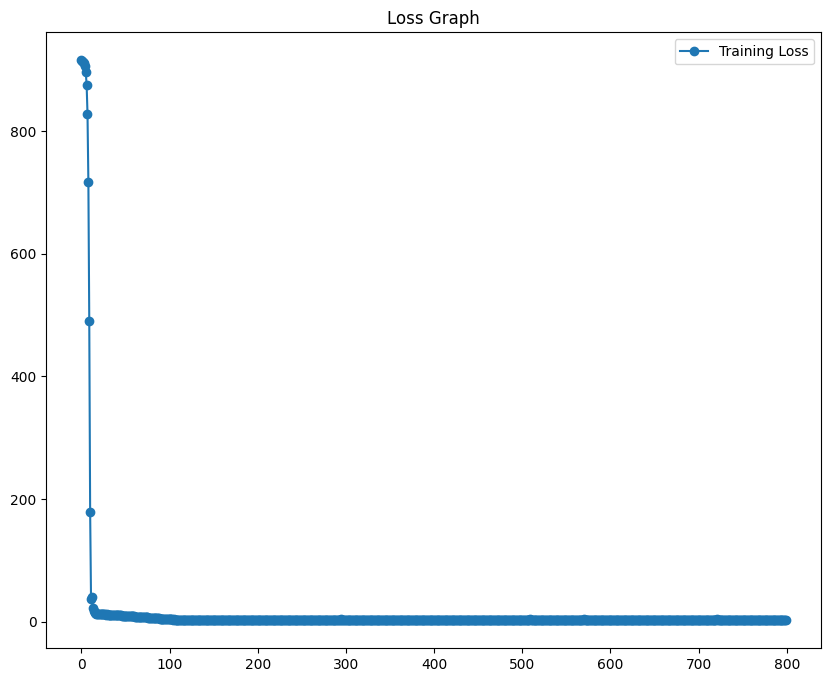

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
LSTM Metrics:
MAE: 1.2523134045962168
R2 Score: 0.9279507087009667
RMSE: 1.6381521135396244
MAPE: 4.131209000187798
VAF: 93.04921960077886
RSR: 0.26841999049816173
A20: 1.0


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
lstm.compile(optimizer=optimizer, loss='mse')

r = lstm.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = lstm.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("LSTM Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [ ]:
y_pred_train = lstm.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("LSTM Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LSTM Train Metrics:
MAE: 1.4022272086662118
R2 Score: 0.9114942290990106
RMSE: 1.8139558989597107
MAPE: 4.633187856553159
VAF: 91.478203643103
RSR: 0.2974991947904892
A20: 1.0


In [ ]:
y_pred_test = lstm.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("LSTM Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
LSTM Test Metrics:
MAE: 0.9133780963530072
R2 Score: 0.964651756344631
RMSE: 1.1451795477442575
MAPE: 2.996301234990118
VAF: 96.5872632148964
RSR: 0.18801128597871197
A20: 1.0


In [ ]:
Train["LSTM Predicted"] = y_pred_train
Test["LSTM Predicted"] = y_pred_test
Full["LSTM Predicted"] = y_pred

## GRU

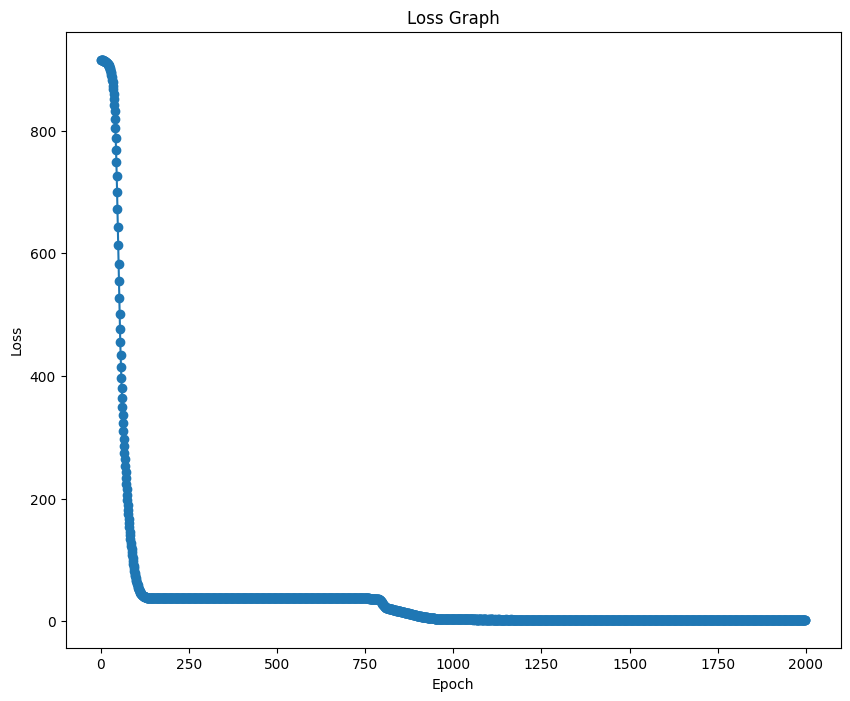

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
GRU Metrics:
MAE: 1.1797017070062743
R2 Score: 0.9339729297418584
RMSE: 1.5681961505674915
MAPE: 3.8589286710241533
VAF: 93.4219652479081
RSR: 0.25695733159056117
A20: 1.0


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

gru = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Use a small learning rate for precise fitting
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
gru.compile(optimizer=optimizer, loss='mse')

# Train for many epochs to allow memorization
r = gru.fit(X_scaled, y, epochs=2000, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions and evaluation
y_pred = gru.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("GRU Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [ ]:
y_pred_train = gru.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("GRU Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
GRU Train Metrics:
MAE: 1.2991460575377185
R2 Score: 0.9188011297451056
RMSE: 1.737464432912945
MAPE: 4.227847822355518
VAF: 91.94383485588567
RSR: 0.28495415465455903
A20: 1.0


In [ ]:
y_pred_test = gru.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("GRU Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
GRU Test Metrics:
MAE: 0.9096536930807757
R2 Score: 0.9678121419049388
RMSE: 1.0927874586832698
MAPE: 3.02485064106272
VAF: 96.7845906836105
RSR: 0.17940974916392136
A20: 1.0


In [ ]:
Train["GRU Predicted"] = y_pred_train
Test["GRU Predicted"] = y_pred_test
Full["GRU Predicted"] = y_pred

## Exporting Results

In [ ]:
Full.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),Actual,ANN Predicted,CNN Predicted,LSTM Predicted,GRU Predicted
0,340.8,1046.4,1249.2,0.0,231.6,22.334836,22.540682,21.825905,22.116240,21.603502
1,340.8,1046.4,1249.2,0.0,231.6,21.718515,22.540682,21.825905,22.116240,21.603502
2,340.8,1046.4,1249.2,0.0,231.6,21.965002,22.540682,21.825905,22.116240,21.603502
3,340.8,1046.4,936.0,272.4,231.6,20.615770,22.819016,21.792559,22.480021,22.418148
4,340.8,1046.4,936.0,272.4,231.6,22.581324,22.819016,21.792559,22.480021,22.418148


In [ ]:
output_dir = "/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/"
Train.to_excel(f"{output_dir}V2_CM_StoneChips_Train.xlsx", index=False)
Test.to_excel(f"{output_dir}V2_CM_StoneChips_Test.xlsx", index=False)
Full.to_excel(f"{output_dir}V2_CM_StoneChips_Full.xlsx", index=False)

# Brick Chips

## EDA

In [14]:
brick_df = pd.read_excel("/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/Bricks CM.xlsx")
brick_df.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),Actual
0,340.8,1083.6,895.2,0.0,231.6,21.595237
1,340.8,1083.6,895.2,0.0,231.6,20.855707
2,340.8,1083.6,895.2,0.0,231.6,20.978985
3,340.8,1083.6,670.8,310.8,231.6,22.819468
4,340.8,1083.6,670.8,310.8,231.6,20.838056


In [15]:
brick_df = brick_df.dropna()
brick_df.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),Actual
0,340.8,1083.6,895.2,0.0,231.6,21.595237
1,340.8,1083.6,895.2,0.0,231.6,20.855707
2,340.8,1083.6,895.2,0.0,231.6,20.978985
3,340.8,1083.6,670.8,310.8,231.6,22.819468
4,340.8,1083.6,670.8,310.8,231.6,20.838056


In [16]:
brick_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Cement (kg/m3)  75 non-null     float64
 1   FA (kg/m3)      75 non-null     float64
 2   CA (kg/m3)      75 non-null     float64
 3   Slag (kg/m3)    75 non-null     float64
 4   Water (kg/m3)   75 non-null     float64
 5   Actual          75 non-null     float64
dtypes: float64(6)
memory usage: 3.6 KB


In [17]:
brick_df.describe()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),Actual
count,75.000000,75.000000,75.000000,75.000000,7.500000e+01,75.000000
mean,408.000000,1038.288000,447.360000,587.280000,2.316000e+02,29.132935
std,50.317693,46.903769,318.632477,397.019278,1.430655e-13,5.863900
min,340.800000,966.000000,0.000000,0.000000,2.316000e+02,18.606020
25%,370.800000,1000.800000,223.200000,310.800000,2.316000e+02,24.615101
50%,405.600000,1029.600000,447.600000,620.400000,2.316000e+02,28.867538
75%,440.400000,1081.200000,670.800000,931.200000,2.316000e+02,34.443491
max,482.400000,1136.400000,895.200000,1074.000000,2.316000e+02,39.467726


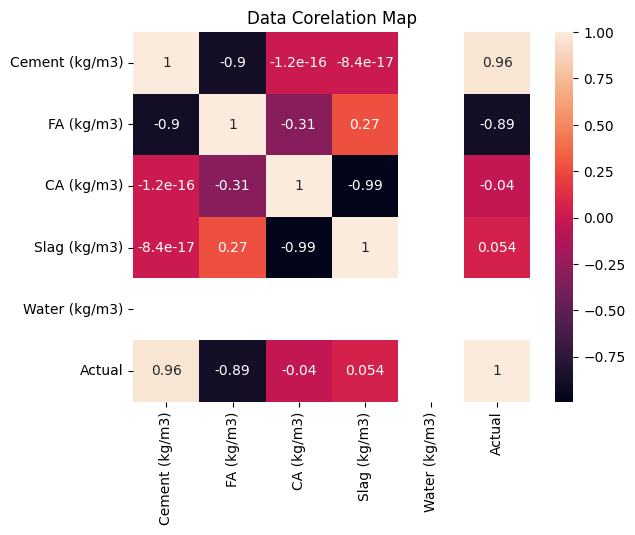

In [18]:
sns.heatmap(brick_df.corr(), annot=True)
plt.title("Data Corelation Map")
plt.show()

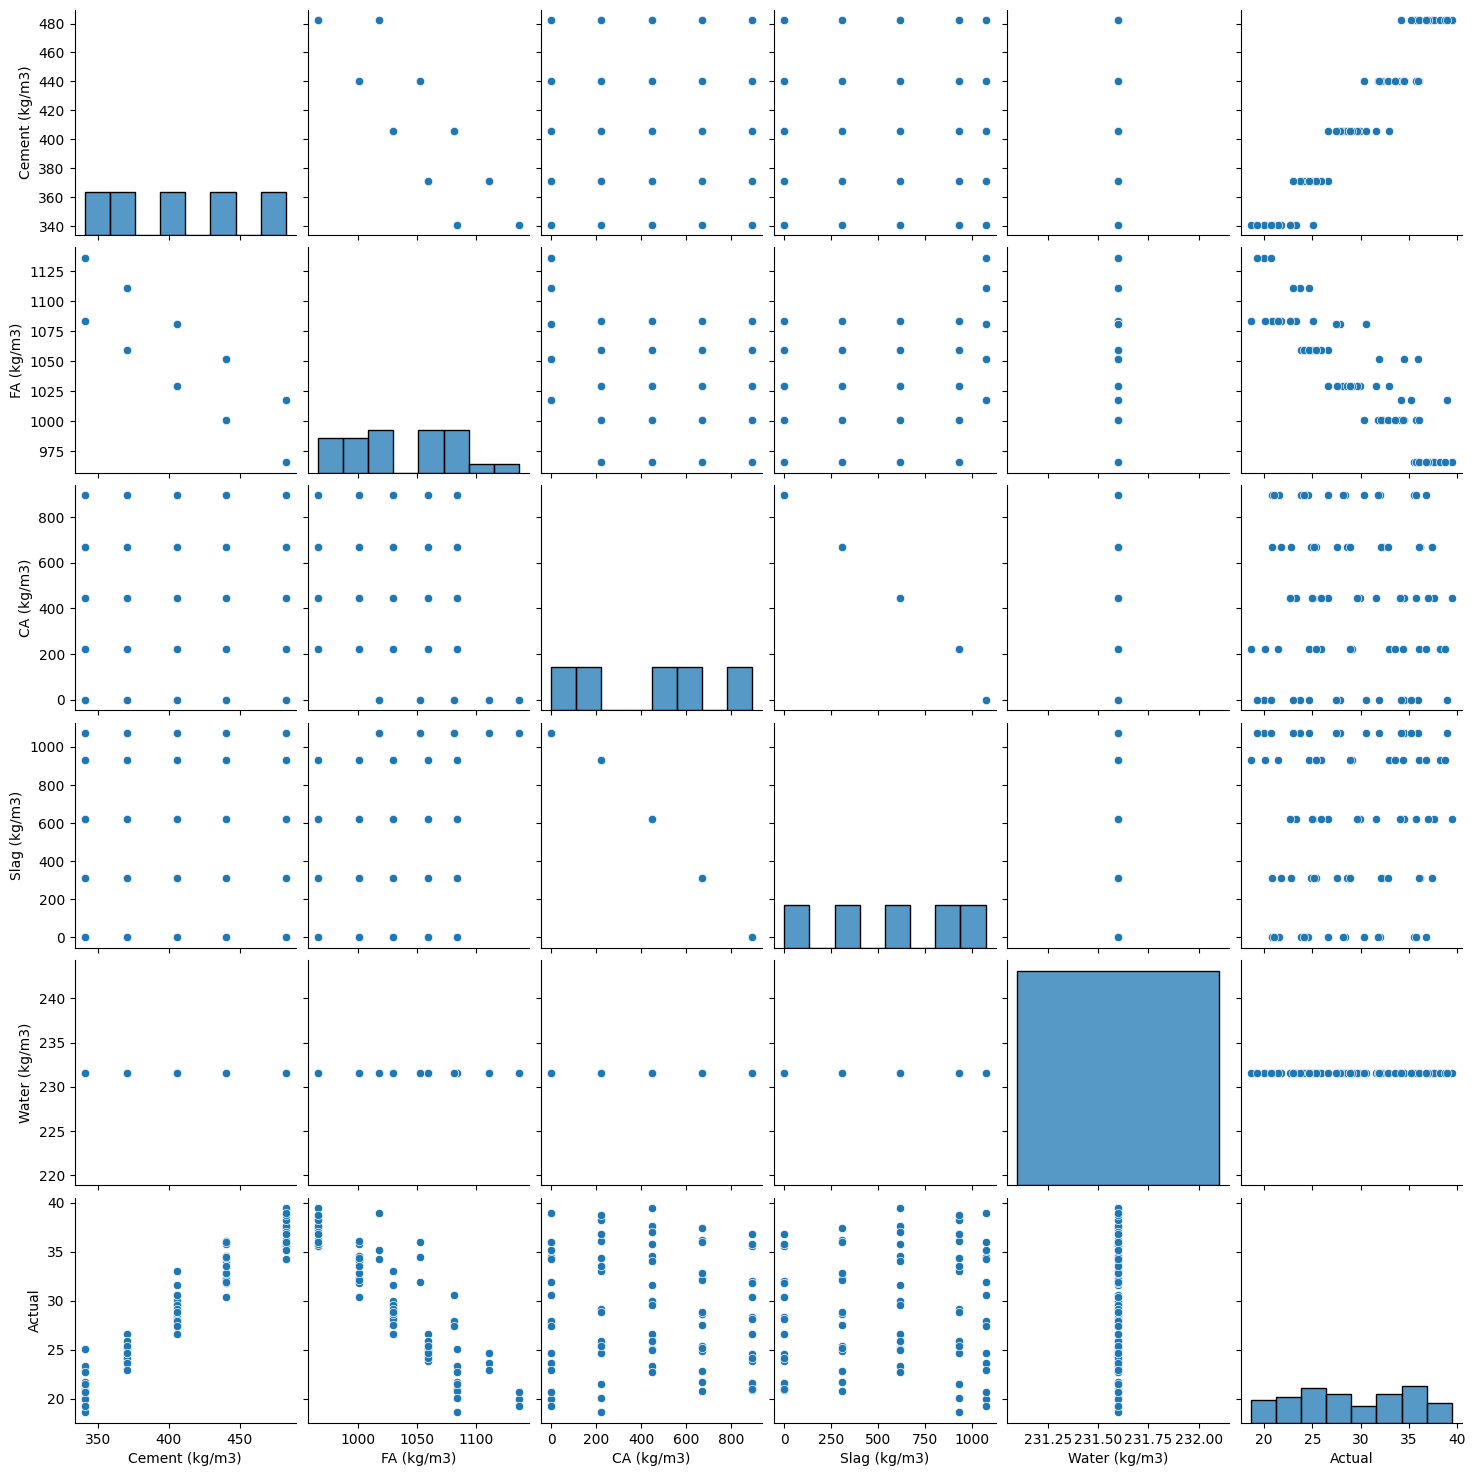

In [19]:
sns.pairplot(brick_df)
plt.show()

## Data Preprocessing

In [20]:
brick_df.columns

Index(['Cement (kg/m3)', 'FA (kg/m3)', 'CA (kg/m3)', 'Slag (kg/m3)',
       'Water (kg/m3)', 'Actual'],
      dtype='object')

In [21]:
X = brick_df.drop("Actual", axis=1)
y = brick_df["Actual"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
# Train = X_train
# Train["Actual"] = y_train
# Test = X_test
# Test["Actual"] = y_test
# Full = X
# Full["Actual"] = y

In [24]:
Train = X_train.copy()
Train["Actual"] = y_train.copy()

Test = X_test.copy()
Test["Actual"] = y_test.copy()

Full = X.copy()
Full["Actual"] = y.copy()

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

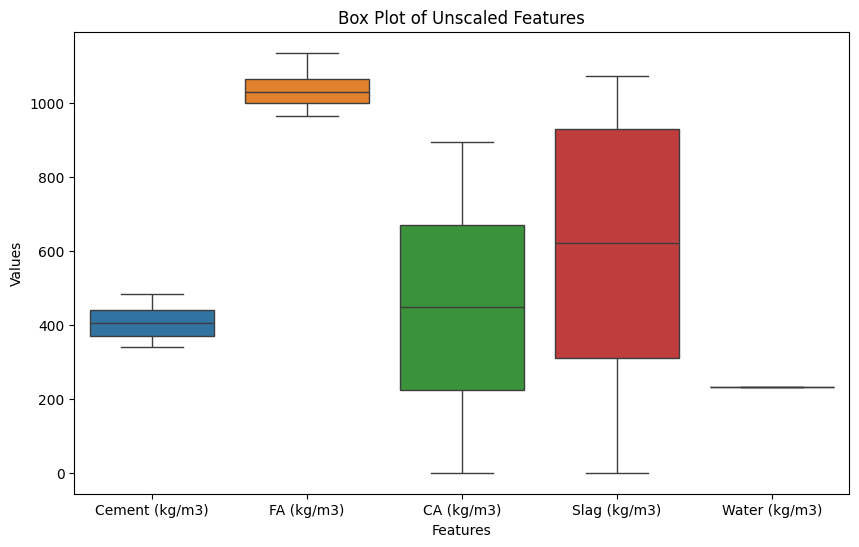

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train)
plt.title("Box Plot of Unscaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
#plt.set_xticklabels(X_train.columns, rotation=45)
plt.show()

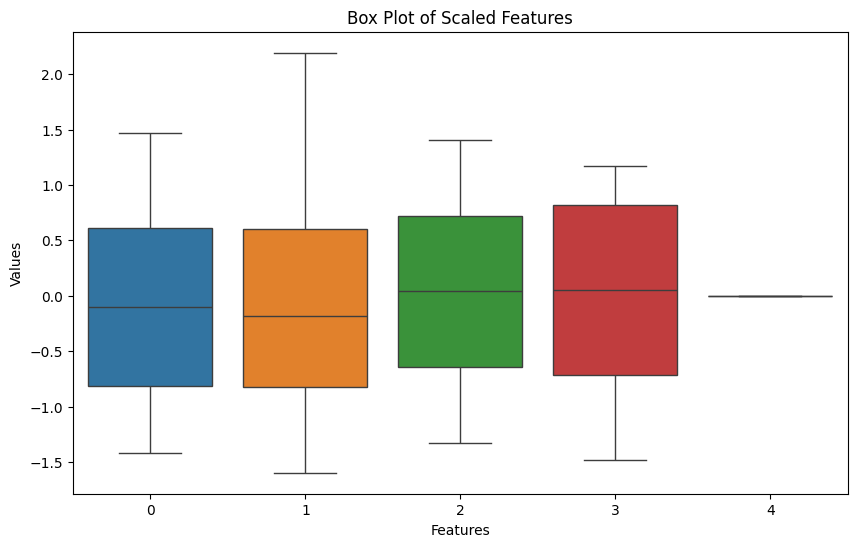

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(X_train_scaled)
plt.title("Box Plot of Scaled Features")
plt.xlabel("Features")
plt.ylabel("Values")
plt.show()

## ANN

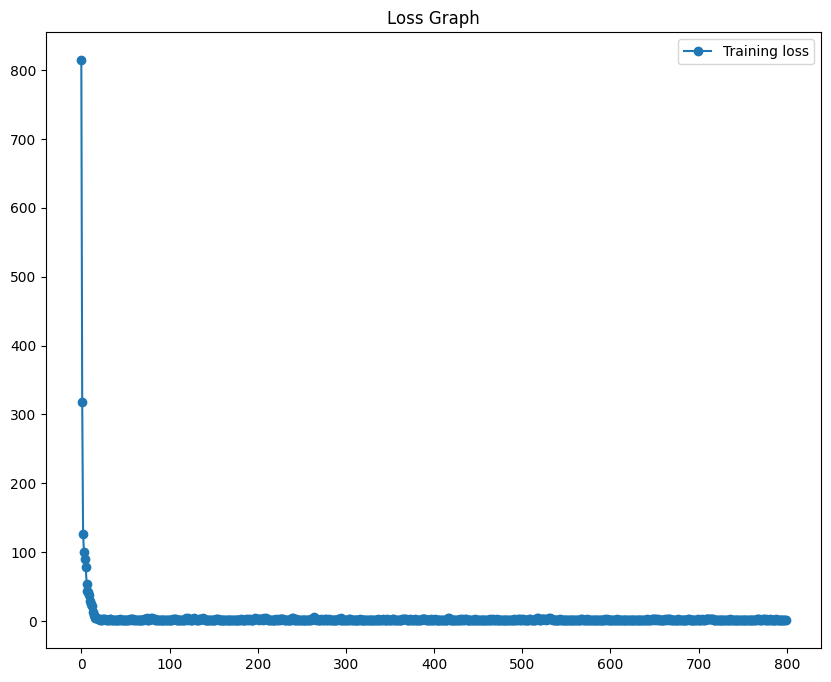

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
ANN Metrics:
MAE: 0.8790792140351297
R2 Score: 0.965248862105189
RMSE: 1.0858161175065937
MAPE: 3.0709148535682407
VAF: 97.08142241200368
RSR: 0.18641657086968152
A20: 1.0


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_scaled.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0002)
ann.compile(optimizer=optimizer, loss='mse')

r = ann.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = ann.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("ANN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [ ]:
y_pred_train = ann.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("ANN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
ANN Train Metrics:
MAE: 0.9047954044890708
R2 Score: 0.9617860038079079
RMSE: 1.125393194518921
MAPE: 3.1503035078314396
VAF: 96.7621929355303
RSR: 0.19548400495204754
A20: 1.0


In [ ]:
y_pred_test = ann.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("ANN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
ANN Test Metrics:
MAE: 0.8209381787762792
R2 Score: 0.9717692709506636
RMSE: 0.9905253837464226
MAPE: 2.891427030600517
VAF: 97.6908602955452
RSR: 0.16802002573900643
A20: 1.0


In [ ]:
Train["ANN Predicted"] = y_pred_train
Test["ANN Predicted"] = y_pred_test
Full["ANN Predicted"] = y_pred

## CNN

In [28]:
n_sample,n_features = X_scaled.shape
print(n_sample,n_features)
X_scaled_reshaped = X_scaled.reshape((n_sample,n_features,1))

75 5


In [29]:
n_sample,n_features = X_train_scaled.shape
print(n_sample,n_features)
X_train_scaled_reshaped = X_train_scaled.reshape((n_sample,n_features,1))

52 5


In [30]:
n_sample,n_features = X_test_scaled.shape
print(n_sample,n_features)
X_test_scaled_reshaped = X_test_scaled.reshape((n_sample,n_features,1))

23 5


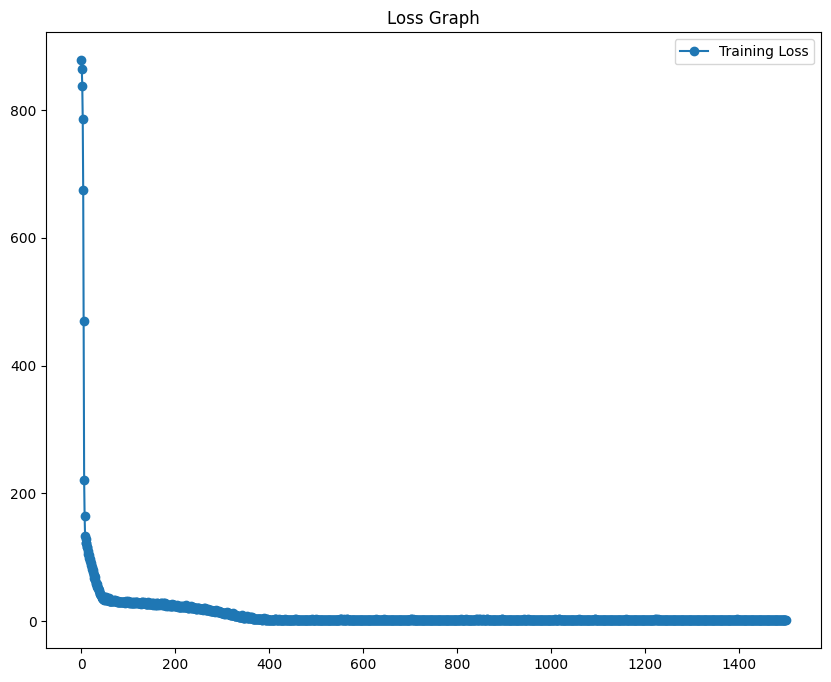

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
CNN Metrics:
MAE: 0.8104674840806211
R2 Score: 0.9665900408150472
RMSE: 1.06465706788064
MAPE: 2.7973546172588684
VAF: 96.6890318297047
RSR: 0.18278391391189994
A20: 1.0


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=1, activation='relu', input_shape=(n_features,1)),
    tf.keras.layers.Conv1D(128, kernel_size=1, activation='relu'),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(256, kernel_size=1, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
cnn.compile(optimizer=optimizer, loss='mse')

r = cnn.fit(X_scaled, y, epochs=1500, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = cnn.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("CNN Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [ ]:
y_pred_train = cnn.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("CNN Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
CNN Train Metrics:
MAE: 0.8874776031173928
R2 Score: 0.9615953239035158
RMSE: 1.1281974398760777
MAPE: 3.022517694317286
VAF: 96.16461180410658
RSR: 0.1959711103619212
A20: 1.0


In [ ]:
y_pred_test = cnn.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("CNN Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
CNN Test Metrics:
MAE: 0.6363575668084143
R2 Score: 0.9764496520746092
RMSE: 0.9046971587717394
MAPE: 2.288290141510907
VAF: 97.80571881052687
RSR: 0.15346122613022095
A20: 1.0


In [ ]:
Train["CNN Predicted"] = y_pred_train
Test["CNN Predicted"] = y_pred_test
Full["CNN Predicted"] = y_pred

## LSTM

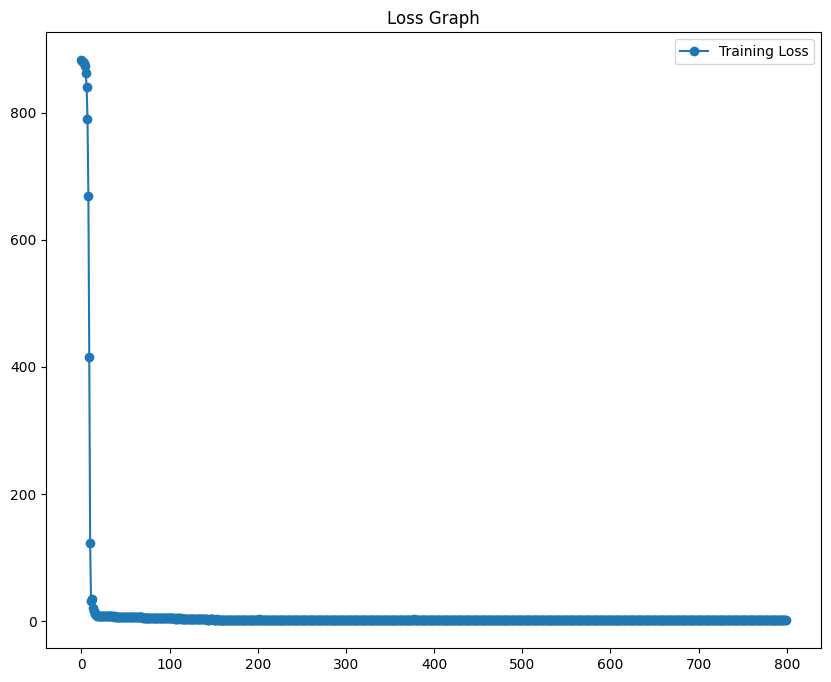

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
LSTM Metrics:
MAE: 0.9070867584134105
R2 Score: 0.9558332890254337
RMSE: 1.2241067666388714
MAPE: 3.163820606498455
VAF: 95.70662374060427
RSR: 0.21015877563063173
A20: 1.0


In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = Adam(learning_rate=0.0001)
lstm.compile(optimizer=optimizer, loss='mse')

r = lstm.fit(X_scaled, y, epochs=800, batch_size=8, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-', label='Training Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

y_pred = lstm.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("LSTM Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [32]:
y_pred_train = lstm.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("LSTM Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
LSTM Train Metrics:
MAE: 0.99684878030565
R2 Score: 0.9468781750620345
RMSE: 1.3268735890871393
MAPE: 3.4460509148405567
VAF: 94.92769877502927
RSR: 0.2304817236527997
A20: 1.0


In [33]:
y_pred_test = lstm.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("LSTM Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
LSTM Test Metrics:
MAE: 0.7041464520766677
R2 Score: 0.9739388969585306
RMSE: 0.9517019502243335
MAPE: 2.5257343166182236
VAF: 97.39638448304862
RSR: 0.16143451626424069
A20: 1.0


In [34]:
Train["LSTM Predicted"] = y_pred_train
Test["LSTM Predicted"] = y_pred_test
Full["LSTM Predicted"] = y_pred

## GRU

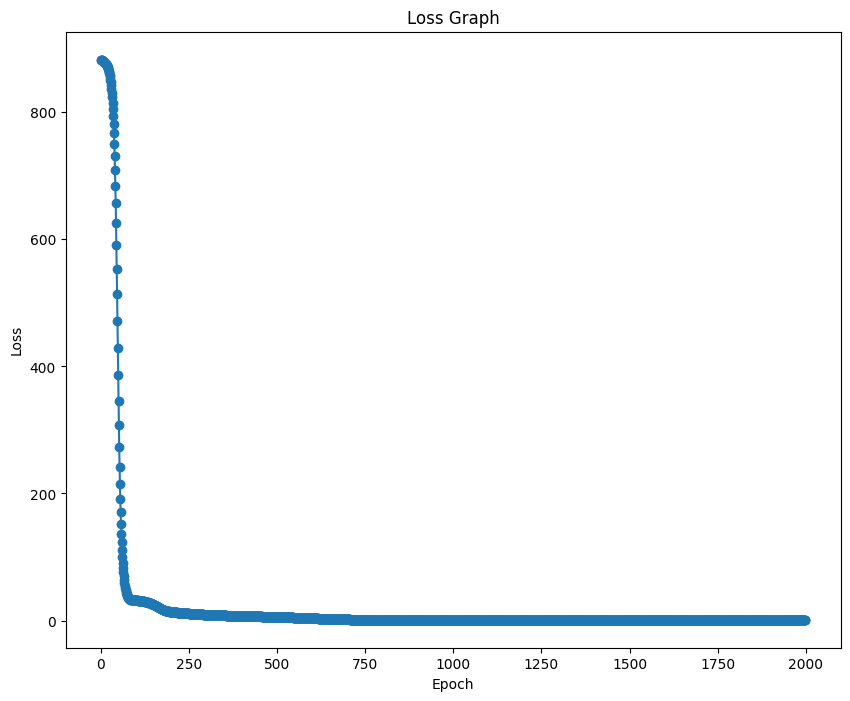

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
GRU Metrics:
MAE: 0.8985297899735383
R2 Score: 0.9605021395708825
RMSE: 1.1576000968490046
MAPE: 3.1287479645790013
VAF: 96.08031307019014
RSR: 0.19874068639591014
A20: 1.0


In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt

gru = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=(n_features, 1)),
    tf.keras.layers.GRU(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Use a small learning rate for precise fitting
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
gru.compile(optimizer=optimizer, loss='mse')

# Train for many epochs to allow memorization
r = gru.fit(X_scaled, y, epochs=2000, verbose=0)

plt.figure(figsize=(10,8))
plt.plot(r.history['loss'], 'o-')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions and evaluation
y_pred = gru.predict(X_scaled)
mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y, y_pred.reshape(-1))
print("GRU Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)


In [36]:
y_pred_train = gru.predict(X_train_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_train, y_pred_train.reshape(-1))
print("GRU Train Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
GRU Train Metrics:
MAE: 0.9364804132291676
R2 Score: 0.955893672750474
RMSE: 1.2090478922411478
MAPE: 3.23395534934816
VAF: 95.59083857037488
RSR: 0.210015064339504
A20: 1.0


In [37]:
y_pred_test = gru.predict(X_test_scaled)

mae, r2, rmse, mape_value, vaf_value, rsr_value, a20 = evaluation_metrics(y_test, y_pred_test.reshape(-1))
print("GRU Test Metrics:")
print("MAE:", mae)
print("R2 Score:", r2)
print("RMSE:", rmse)
print("MAPE:", mape_value)
print("VAF:", vaf_value)
print("RSR:", rsr_value)
print("A20:", a20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GRU Test Metrics:
MAE: 0.8127282150174516
R2 Score: 0.9693633434635884
RMSE: 1.0318706183862942
MAPE: 2.8908872319819148
VAF: 97.16126604917612
RSR: 0.17503330122125788
A20: 1.0


In [38]:
Train["GRU Predicted"] = y_pred_train
Test["GRU Predicted"] = y_pred_test
Full["GRU Predicted"] = y_pred

## Exporting Results

In [ ]:
Full.head()

,Cement (kg/m3),FA (kg/m3),CA (kg/m3),Slag (kg/m3),Water (kg/m3),Actual,ANN Predicted,CNN Predicted,LSTM Predicted,GRU Predicted
0,340.8,1083.6,895.2,0.0,231.6,21.595237,21.312002,21.236292,21.522907,21.129438
1,340.8,1083.6,895.2,0.0,231.6,20.855707,21.312002,21.236292,21.522907,21.129438
2,340.8,1083.6,895.2,0.0,231.6,20.978985,21.312002,21.236292,21.522907,21.129438
3,340.8,1083.6,670.8,310.8,231.6,22.819468,22.266907,21.039984,21.754435,21.769535
4,340.8,1083.6,670.8,310.8,231.6,20.838056,22.266907,21.039984,21.754435,21.769535


In [ ]:
output_dir = "/content/drive/MyDrive/Projects/28. Materials (Stone & Bricks)/NDT V2/"
Train.to_excel(f"{output_dir}V2_CM_BrickChips_Train.xlsx", index=False)
Test.to_excel(f"{output_dir}V2_CM_BrickChips_Test.xlsx", index=False)
Full.to_excel(f"{output_dir}V2_CM_BrickChips_Full.xlsx", index=False)